In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
conf = SparkConf().setAppName("CSC 510 Assignment 2").setMaster("spark://127.0.0.1:7077")
sc = SparkContext.getOrCreate(conf)

In [3]:
sc

<SparkContext master=spark://127.0.0.1:7077 appName=CSC 510 Assignment 2>

In [4]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [5]:
import random, numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D

## *Comparison of Regression Models*

**Standard Regression**

*1-D Data Domain*

In [6]:
def generate_1D_points(length):
    x = np.array(np.round(np.array([random.uniform(0, 5) for x in range(length)]), decimals=1))
    y = np.array(np.round(np.array([random.uniform(0, 10) for y in range(length)]), decimals=1))
    return x,y

In [7]:
def std_reg_1D(x,y):
    X = np.vstack([x, np.ones(len(x))]).T
    A = (np.linalg.inv(X.T.dot(X)).dot(X.T)).dot(y)
    xt = [0,4]
    yt = A * xt
    title = ('Standard Regression of x and y (%d Observations)' % len(x))
    plt.figure(figsize=(10,8)).suptitle(title, fontsize=20)
    plt.scatter(x, y, label='x and y Values')
    plt.plot(xt, yt, 'r', label='Line of Best Fit')
    plt.xlabel("Feature 1", fontsize=18)
    plt.ylabel("Feature 2", fontsize=18)
    plt.axis([0,4,0,12])
    plt.grid(True)
    plt.legend(fontsize=18)
    plt.show()

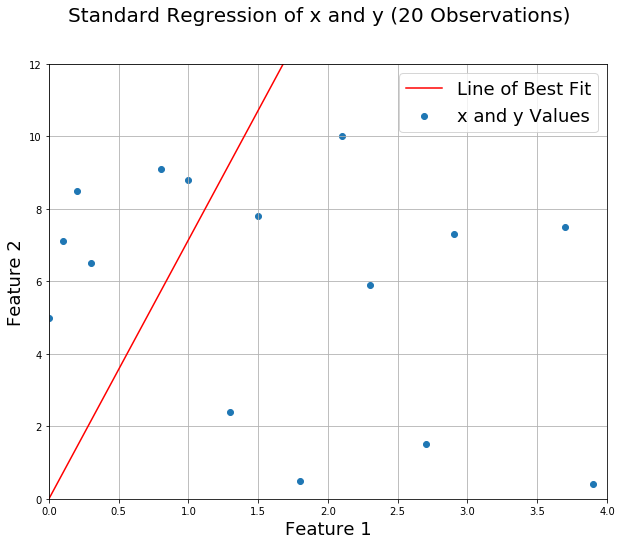

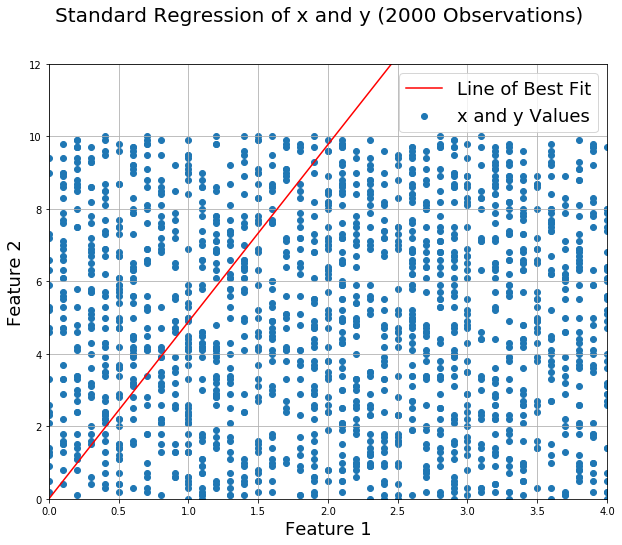

In [8]:
x_20,y_20 = generate_1D_points(20)
std_reg_1D(x_20,y_20)

x_2000,y_2000 = generate_1D_points(2000)
std_reg_1D(x_2000,y_2000)

2-D Data Domain

In [9]:
def generate_2D_points(length):
    x1 = np.array(np.round(np.array([random.uniform(0, 5) for x in range(length)]), decimals=1))
    x2 = np.array(np.round(np.array([random.uniform(0, 5) for x in range(length)]), decimals=1))
    yy = np.array(np.round(np.array([random.uniform(0, 10) for y in range(length)]), decimals=1))
    return x1,x2,yy

In [10]:
def std_reg_2D(x1,x2,yy):
    XX = np.vstack([x1, x2]).T
    AA = (np.linalg.inv(XX.T.dot(XX)).dot(XX.T)).dot(yy)
    xx1 = [0,0,4,4]
    xx2 = [0,4,0,4]
    xxx = [xx1,xx2]
    yy1 = np.matmul(AA,xxx)
    yy2 = np.reshape(yy1,(2,2))
    mg1,mg2 = np.meshgrid([0,4],[0,4])
    figure = plt.figure(figsize=(12,10))
    ax = figure.add_subplot(111, projection='3d')
    title = ('Standard Regression of x1, x2, and yy (%d Observations)' % len(x1))
    figure.suptitle(title, fontsize=20)
    ax.scatter(x1,x2,yy,label='x1, x2, and yy Values',c='r')
    ax.plot_surface(mg1,mg2,yy2,label='Line of Best Fit',color='b')
    ax.set_xlabel("Feature 1", fontsize=16)
    ax.set_ylabel("Feature 2", fontsize=16)
    ax.set_zlabel("Responses",fontsize=16)

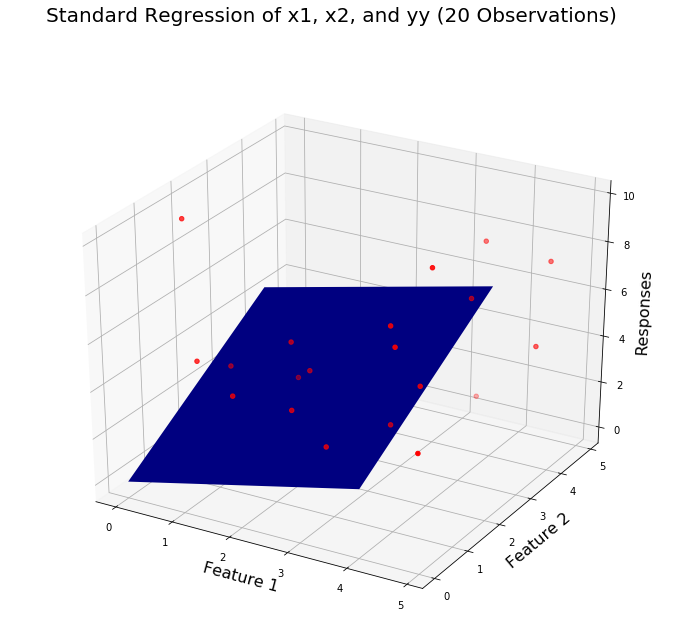

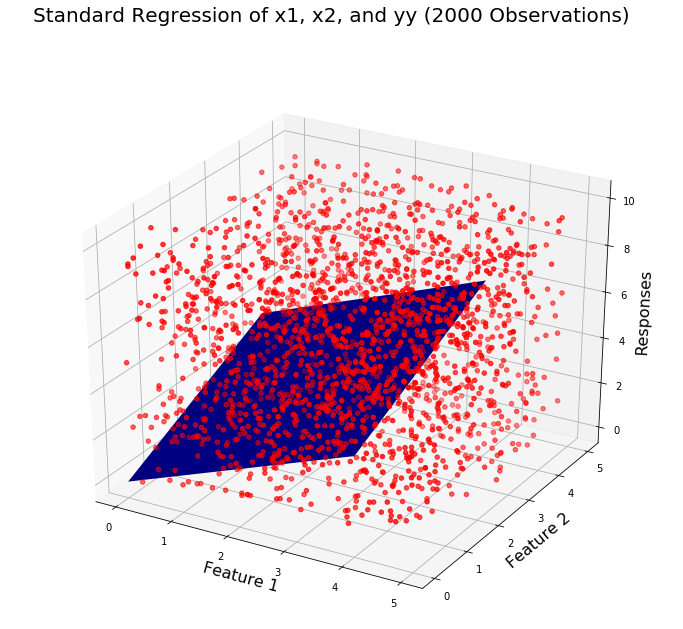

In [11]:
x1_20,x2_20,yy_20 = generate_2D_points(20)
std_reg_2D(x1_20,x2_20,yy_20)

x1_2000,x2_2000,yy_2000 = generate_2D_points(2000)
std_reg_2D(x1_2000,x2_2000,yy_2000)

**Ridge Recession**

*1-D Data Domain*

In [12]:
def ridge_reg_1D(x,y):
    _lambda = 0.1
    X = np.vstack([x, np.ones(len(x))]).T
    A = (np.linalg.inv(X.T.dot(X) + _lambda).dot(X.T)).dot(y)
    xt = [0,4]
    yt = A * xt
    title = ('Ridge Regression of x and y (%d Observations)' % len(x))
    plt.figure(figsize=(10,8)).suptitle(title, fontsize=20)
    plt.scatter(x, y, label='x and y Values')
    plt.plot(xt, yt, 'r', label='Line of Best Fit')
    plt.xlabel("Feature 1", fontsize=18)
    plt.ylabel("Feature 2", fontsize=18)
    plt.axis([0,4,0,12])
    plt.grid(True)
    plt.legend(fontsize=18)
    plt.show()

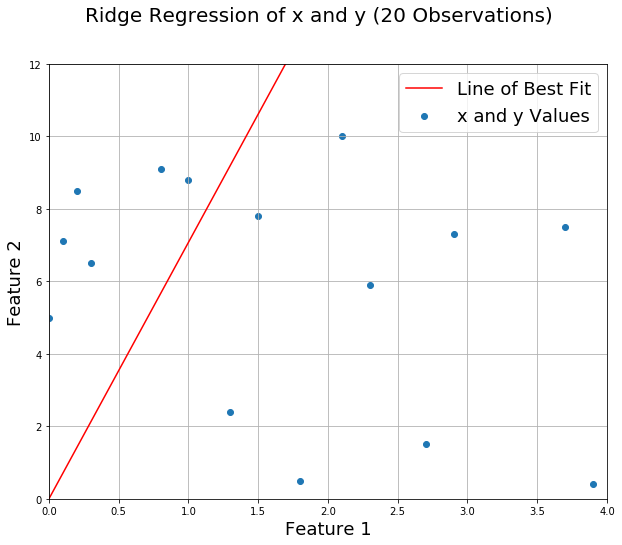

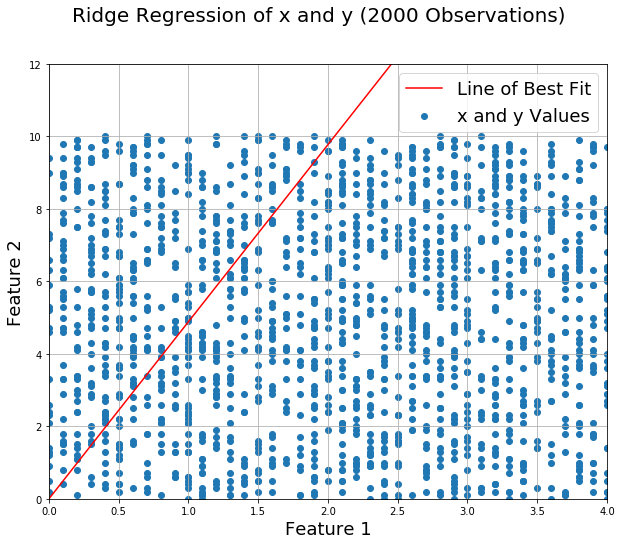

In [13]:
ridge_reg_1D(x_20,y_20)

ridge_reg_1D(x_2000,y_2000)

*2-D Data Domain*

In [14]:
def ridge_reg_2D(x1,x2,yy):
    _lambda = 0.1
    XX = np.vstack([x1, x2]).T
    nn = len(XX.T.dot(XX))
    AA = (np.linalg.inv(XX.T.dot(XX) + (_lambda * np.eye(nn)))).dot(XX.T).dot(yy)
    xx1 = [0,0,4,4]
    xx2 = [0,4,0,4]
    xxx = [xx1,xx2]
    yy1 = np.matmul(AA,xxx)
    yy2 = np.reshape(yy1,(2,2))
    mg1,mg2 = np.meshgrid([0,4],[0,4])
    figure = plt.figure(figsize=(12,10))
    ax = figure.add_subplot(111, projection='3d')
    title = ('Ridge Regression of x1, x2, and yy (%d Observations)' % len(x1))
    figure.suptitle(title, fontsize=20)
    ax.scatter(x1,x2,yy,label='x1, x2, and yy Values',c='r')
    ax.plot_surface(mg1,mg2,yy2,label='Line of Best Fit',color='b')
    ax.set_xlabel("Feature 1", fontsize=16)
    ax.set_ylabel("Feature 2", fontsize=16)
    ax.set_zlabel("Responses",fontsize=16)

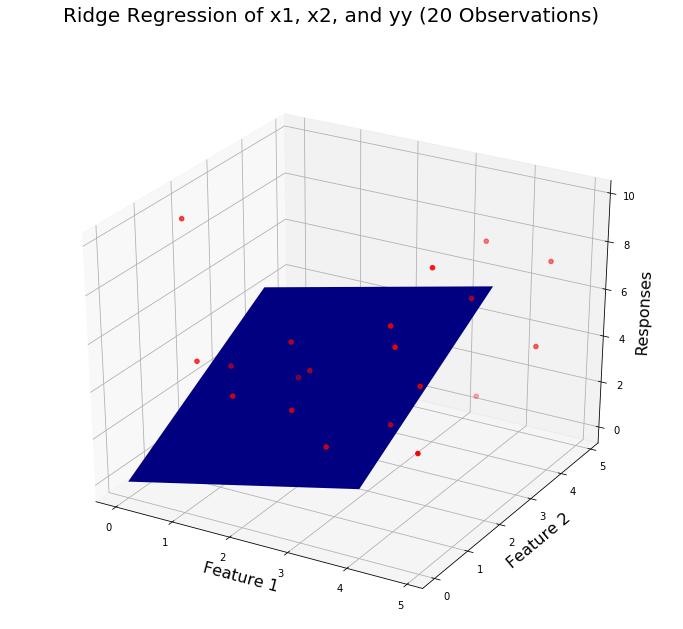

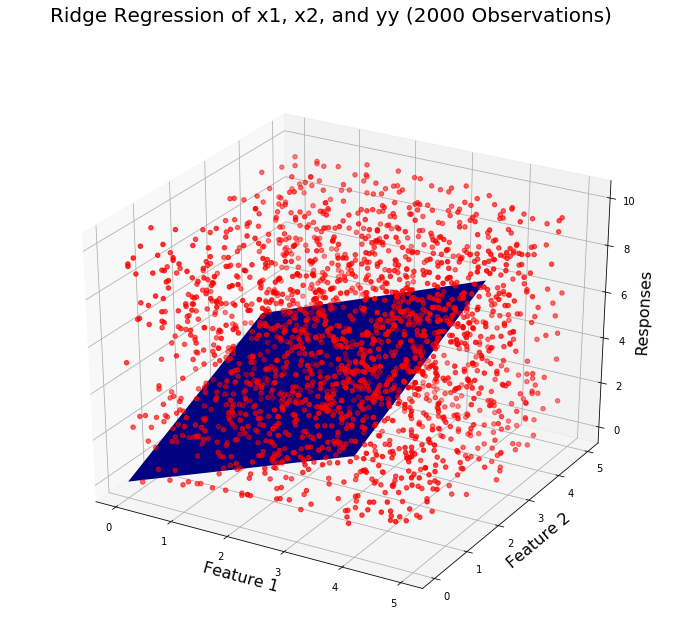

In [15]:
ridge_reg_2D(x1_20,x2_20,yy_20)

ridge_reg_2D(x1_2000,x2_2000,yy_2000)

**Lasso Regression**

*1-D Data Domain*

In [16]:
def lasso_reg_1D(x,y):
    _lambda = 0.1
    X = np.vstack([x, np.ones(len(x))]).T
    A1 = (np.linalg.inv(X.T.dot(X)).dot(X.T)).dot(y)
    S = np.sign(A1)
    A = (np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y) - (S * _lambda / 2)))
    xt = [0,4]
    yt = A * xt
    title = ('Lasso Regression of x and y (%d Observations)' % len(x))
    plt.figure(figsize=(10,8)).suptitle(title, fontsize=20)
    plt.scatter(x, y, label='x and y Values')
    plt.plot(xt, yt, 'r', label='Line of Best Fit')
    plt.xlabel("Feature 1", fontsize=18)
    plt.ylabel("Feature 2", fontsize=18)
    plt.axis([0,4,0,12])
    plt.grid(True)
    plt.legend(fontsize=18)
    plt.show()

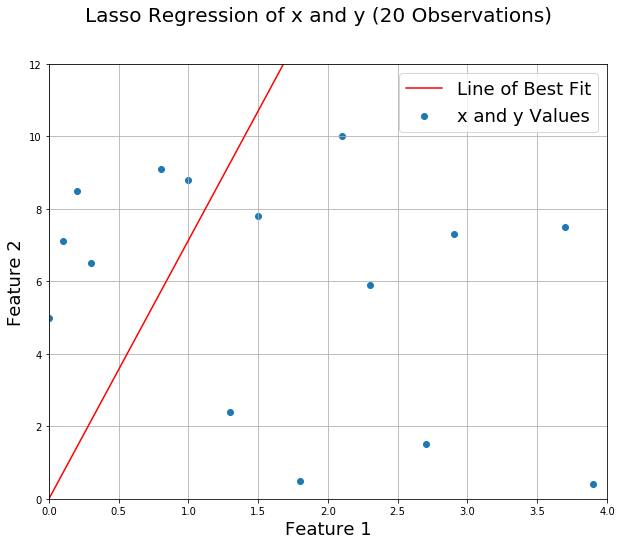

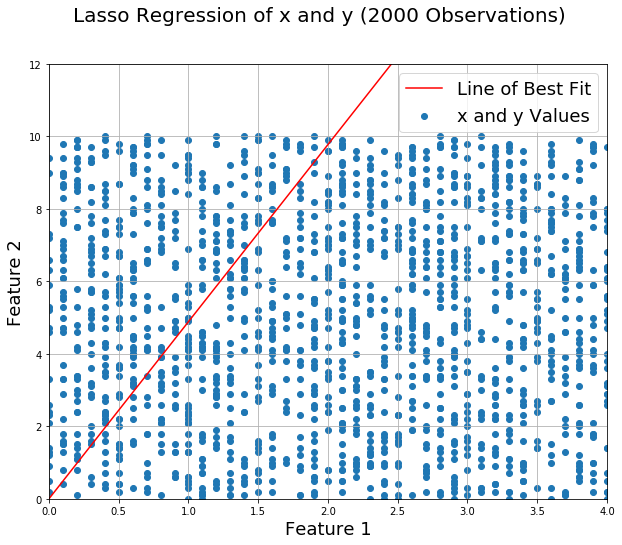

In [17]:
lasso_reg_1D(x_20,y_20)

lasso_reg_1D(x_2000,y_2000)

In [18]:
def lasso_reg_2D(x1,x2,yy):
    _lambda = 0.1
    XX = np.vstack([x1, x2]).T
    nn = len(XX.T.dot(XX))
    AA1 = (np.linalg.inv(XX.T.dot(XX))).dot(XX.T).dot(yy)
    SS = np.sign(AA1)
    AA = (np.linalg.inv(XX.T.dot(XX)).dot(XX.T.dot(yy) - (SS * _lambda / 2)))
    xx1 = [0,0,4,4]
    xx2 = [0,4,0,4]
    xxx = [xx1,xx2]
    yy1 = np.matmul(AA,xxx)
    yy2 = np.reshape(yy1,(2,2))
    mg1,mg2 = np.meshgrid([0,4],[0,4])
    figure = plt.figure(figsize=(12,10))
    ax = figure.add_subplot(111, projection='3d')
    title = ('Lasso Regression of x1, x2, and yy (%d Observations)' % len(x1))
    figure.suptitle(title, fontsize=20)
    ax.scatter(x1,x2,yy,label='x1, x2, and yy Values',c='r')
    ax.plot_surface(mg1,mg2,yy2,label='Line of Best Fit',color='b')
    ax.set_xlabel("Feature 1", fontsize=16)
    ax.set_ylabel("Feature 2", fontsize=16)
    ax.set_zlabel("Responses",fontsize=16)

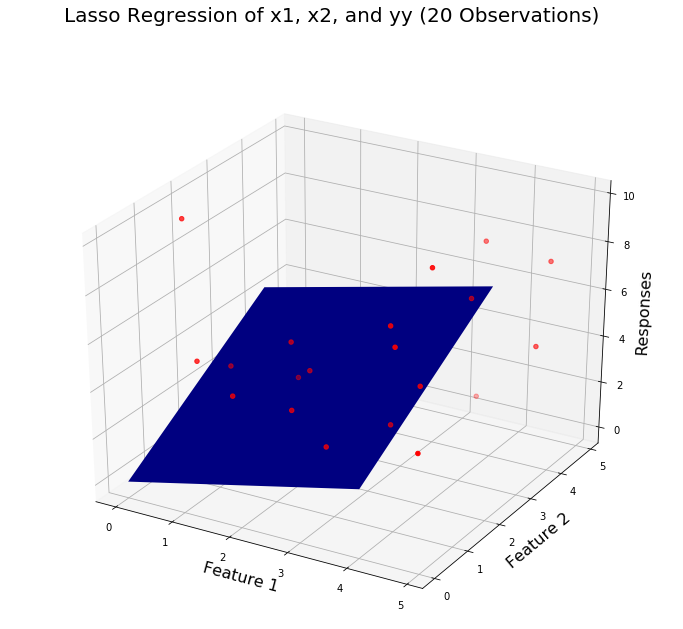

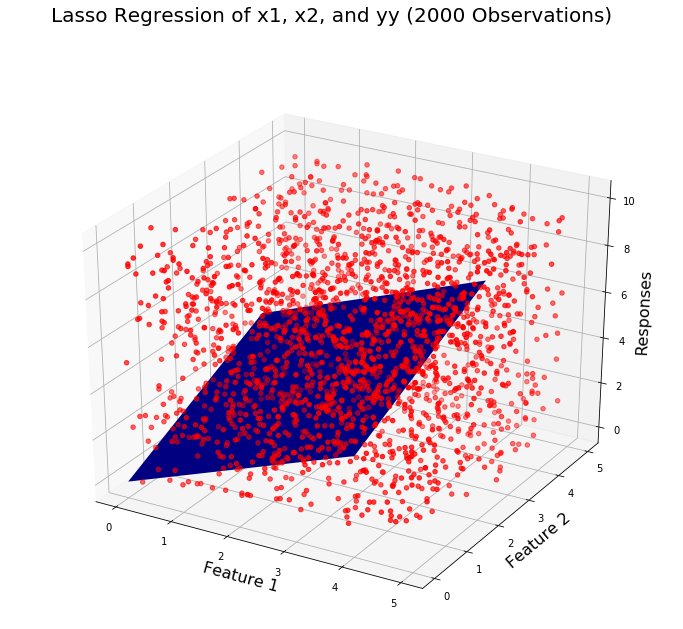

In [19]:
lasso_reg_2D(x1_20,x2_20,yy_20)

lasso_reg_2D(x1_2000,x2_2000,yy_2000)

**Elastic-Net Regression**

*1-D Data Domain*

In [20]:
def en_reg_1D(x,y):
    lambda1 = 0.1
    lambda2 = 0.2
    X = np.vstack([x, np.ones(len(x))]).T
    A1 = (np.linalg.inv(X.T.dot(X)).dot(X.T)).dot(y)
    S = np.sign(A1)
    A = (np.linalg.inv(X.T.dot(X) + lambda1).dot(X.T.dot(y) - (S * lambda2 / 2)))
    xt = [0,4]
    yt = A * xt
    title = ('Elasctic-Net Regression of x and y (%d Observations)' % len(x))
    plt.figure(figsize=(10,8)).suptitle(title, fontsize=20)
    plt.scatter(x, y, label='x and y Values')
    plt.plot(xt, yt, 'r', label='Line of Best Fit')
    plt.xlabel("Feature 1", fontsize=18)
    plt.ylabel("Feature 2", fontsize=18)
    plt.axis([0,4,0,12])
    plt.grid(True)
    plt.legend(fontsize=18)
    plt.show()

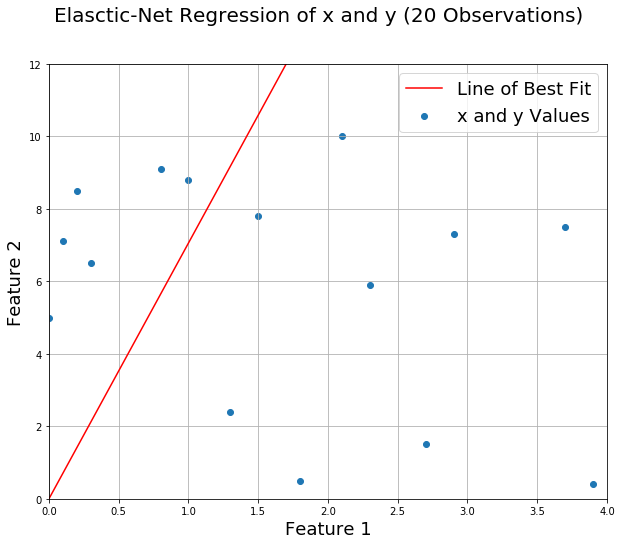

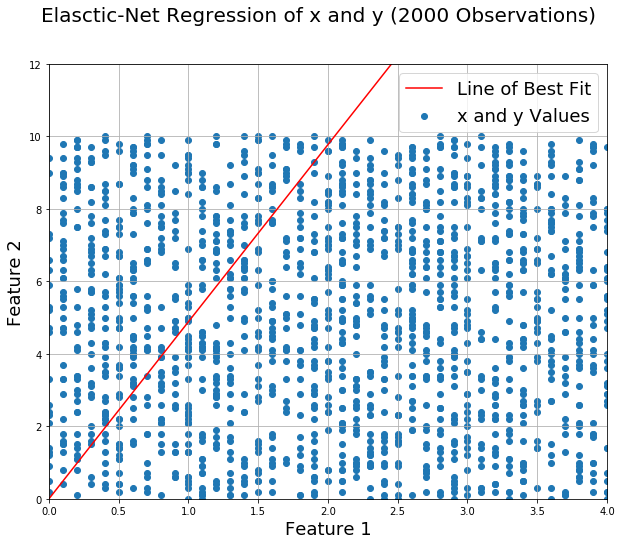

In [21]:
en_reg_1D(x_20,y_20)

en_reg_1D(x_2000,y_2000)

*2-D Data Domain*

In [22]:
def en_reg_2D(x1,x2,yy):
    lambda1 = 0.1
    lambda2 = 0.2
    XX = np.vstack([x1, x2]).T
    nn = len(XX.T.dot(XX))
    AA1 = (np.linalg.inv(XX.T.dot(XX))).dot(XX.T).dot(yy)
    SS = np.sign(AA1)
    AA = (np.linalg.inv(XX.T.dot(XX) + (lambda1 * np.eye(nn))).dot(XX.T.dot(yy) - (SS * lambda2 / 2)))
    xx1 = [0,0,4,4]
    xx2 = [0,4,0,4]
    xxx = [xx1,xx2]
    yy1 = np.matmul(AA,xxx)
    yy2 = np.reshape(yy1,(2,2))
    mg1,mg2 = np.meshgrid([0,4],[0,4])
    figure = plt.figure(figsize=(12,10))
    ax = figure.add_subplot(111, projection='3d')
    title = ('Elastic-Net Regression of x1, x2, and yy (%d Observations)' % len(x1))
    figure.suptitle(title, fontsize=20)
    ax.scatter(x1,x2,yy,label='x1, x2, and yy Values',c='r')
    ax.plot_surface(mg1,mg2,yy2,label='Line of Best Fit',color='b')
    ax.set_xlabel("Feature 1", fontsize=16)
    ax.set_ylabel("Feature 2", fontsize=16)
    ax.set_zlabel("Responses",fontsize=16)

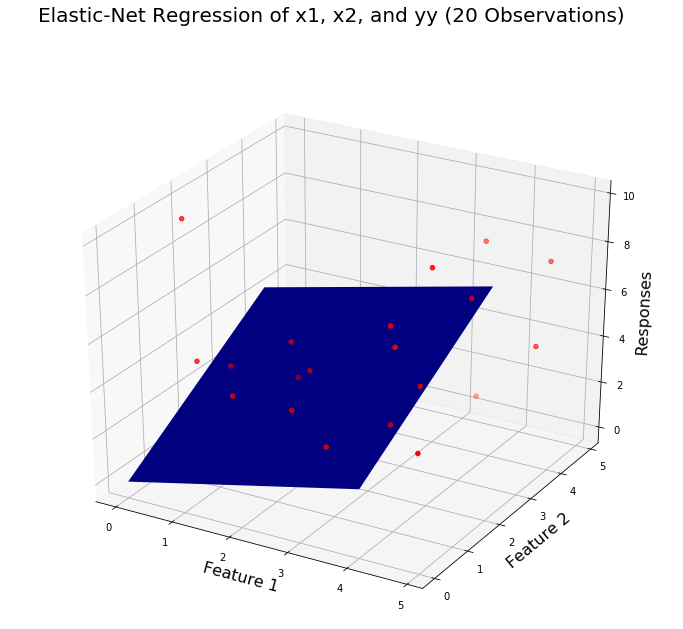

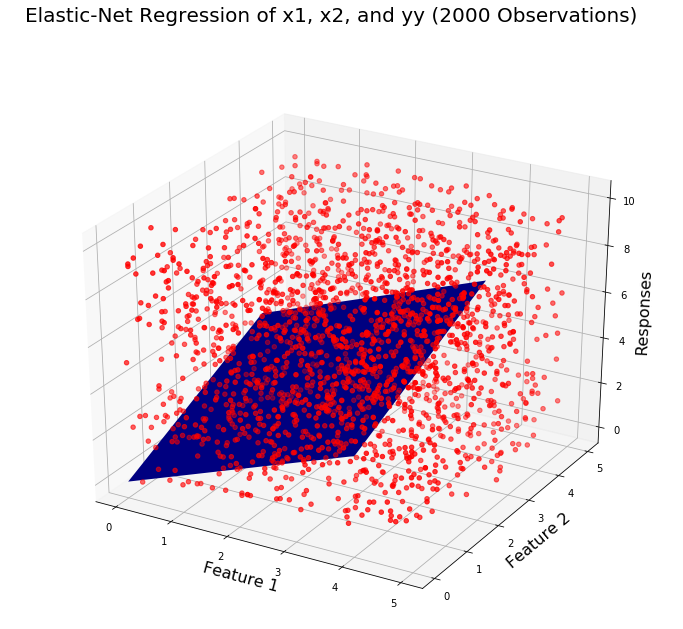

In [23]:
en_reg_2D(x1_20,x2_20,yy_20)

en_reg_2D(x1_2000,x2_2000,yy_2000)

In [24]:
recent_grads = sqlContext.read.csv("../../data/CSC-510_Assignment2_Data/recent-grads.csv", inferSchema="true", header=True)
grads = sqlContext.read.csv("../../data/CSC-510_Assignment2_Data/grad-students.csv", inferSchema="true", header=True)

In [25]:
recent_feats = [dt[0] for dt in recent_grads.dtypes if dt[1] == 'int' or dt[1] == 'double']
grad_feats = [dt[0] for dt in grads.dtypes if dt[1] == 'int' or dt[1] == 'double']
print(recent_feats)
print(grad_feats)

['Rank', 'Major_code', 'Total', 'Men', 'Women', 'ShareWomen', 'Sample_size', 'Employed', 'Full_time', 'Part_time', 'Full_time_year_round', 'Unemployed', 'Unemployment_rate', 'Median', 'P25th', 'P75th', 'College_jobs', 'Non_college_jobs', 'Low_wage_jobs']
['Major_code', 'Grad_total', 'Grad_sample_size', 'Grad_employed', 'Grad_full_time_year_round', 'Grad_unemployed', 'Grad_unemployment_rate', 'Grad_P25', 'Nongrad_total', 'Nongrad_employed', 'Nongrad_full_time_year_round', 'Nongrad_unemployed', 'Nongrad_unemployment_rate', 'Nongrad_P25', 'Grad_share', 'Grad_premium']


In [26]:
from pyspark.sql import functions
pop_major_rg = [item[0] for item in recent_grads.groupby(recent_grads.Major_category)
                .agg(functions.sum('Total').alias('Popularity')).orderBy('Popularity', ascending=False)
                .collect()][:2]
pop_major_g = [item[0] for item in grads.groupby(grads.Major_category)
               .agg(functions.sum('Grad_total').alias('Popularity')).orderBy('Popularity', ascending=False)
               .collect()][:2]
rg_x1 = np.array([item[0]/10000 for item in recent_grads[recent_grads.Major_category.isin(pop_major_rg)].select('Employed').collect()])
rg_x2 = np.array([item[0]/10000 for item in recent_grads[recent_grads.Major_category.isin(pop_major_rg)].select('Unemployed').collect()])
rg_yy = np.array([item[0] for item in recent_grads[recent_grads.Major_category.isin(pop_major_rg)].select('Unemployment_rate').collect()])

g_x1 = np.array([item[0]/10000 for item in grads[grads.Major_category.isin(pop_major_g)].select('Grad_employed').collect()])
g_x2 = np.array([item[0]/10000 for item in grads[grads.Major_category.isin(pop_major_g)].select('Grad_unemployed').collect()])
g_yy = np.array([item[0] for item in grads[grads.Major_category.isin(pop_major_g)].select('Grad_unemployment_rate').collect()])

In [27]:
print(rg_x1)
print(rg_x2)
print(rg_yy)
print(g_x1)
print(g_x2)
print(g_yy)

[ 0.2912  1.6413  1.0027 14.5696  1.0914 16.5527 19.0183  1.966   1.4826
  0.2787 27.6234 17.8862  2.076   2.4629 10.5646  3.8315  1.8824  3.6728
  1.1165  4.0157 14.918   5.4844  1.7579  0.5052  2.4202  2.9633  0.7052
  1.5053]
[0.0308 0.1015 0.0504 0.9413 0.1165 1.2411 1.4946 0.2092 0.115  0.0138
 2.1502 1.1663 0.1315 0.1668 1.1176 0.3132 0.1718 0.2393 0.1302 0.4267
 1.4345 0.4657 0.1128 0.0372 0.1617 0.3395 0.0846 0.134 ]
[0.09565217 0.05823961 0.0478587  0.06068636 0.09644838 0.06974901
 0.07286147 0.09617506 0.07198297 0.04717949 0.07221834 0.06121506
 0.05956965 0.06342929 0.09566691 0.07556639 0.08363353 0.06116919
 0.10443571 0.09605168 0.08772359 0.07826759 0.06029828 0.06858407
 0.0626283  0.10279157 0.10711573 0.08174221]
[15.4404  1.6723  6.3027  1.9264  4.0441  2.6153 13.1845 11.5266  8.6566
 66.8185 69.8049 12.3145  4.0277  8.3632 59.8806  4.6866  3.1558  6.5878
 45.4797 14.5043  6.8997 12.8469  1.2217 12.226   5.175   4.2043 18.2113
 14.4858  1.5651  1.1313  3.4142]
[0.6

**Standard Regression**

*1-D Data Domain*

In [28]:
def grad_std_reg_1D(x,y):
    X = np.vstack([x, np.ones(len(x))]).T
    A = (np.linalg.inv(X.T.dot(X)).dot(X.T)).dot(y)
    xt = [0,4]
    yt = A * xt
    title = ('Standard Regression of unemployment and unemployment_rate (%d Observations)' % len(x))
    plt.figure(figsize=(10,8)).suptitle(title, fontsize=20)
    plt.scatter(x, y, label='unemployment and unemployment_rate Values')
    plt.plot(xt, yt, 'r', label='Line of Best Fit')
    plt.xlabel("unemployment * 1000", fontsize=18)
    plt.ylabel("unemployment_rate", fontsize=18)
    plt.grid(True)
    plt.legend(fontsize=18)
    plt.show()

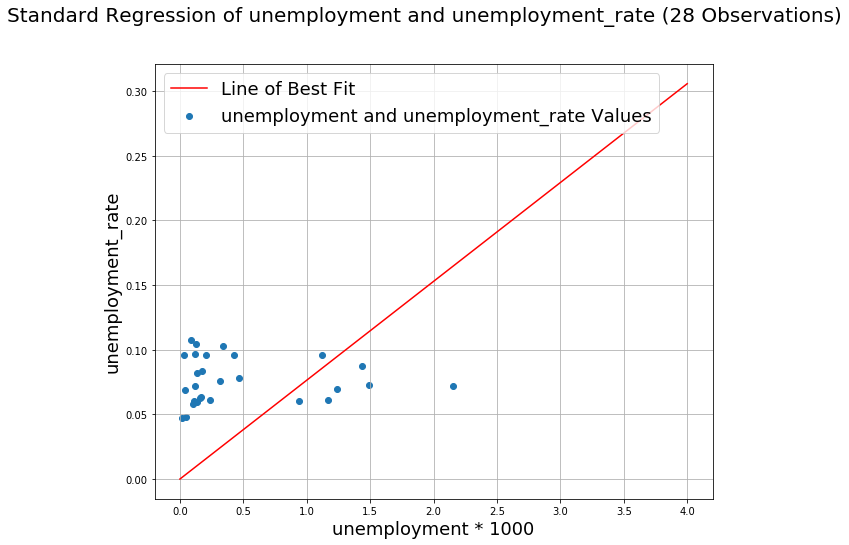

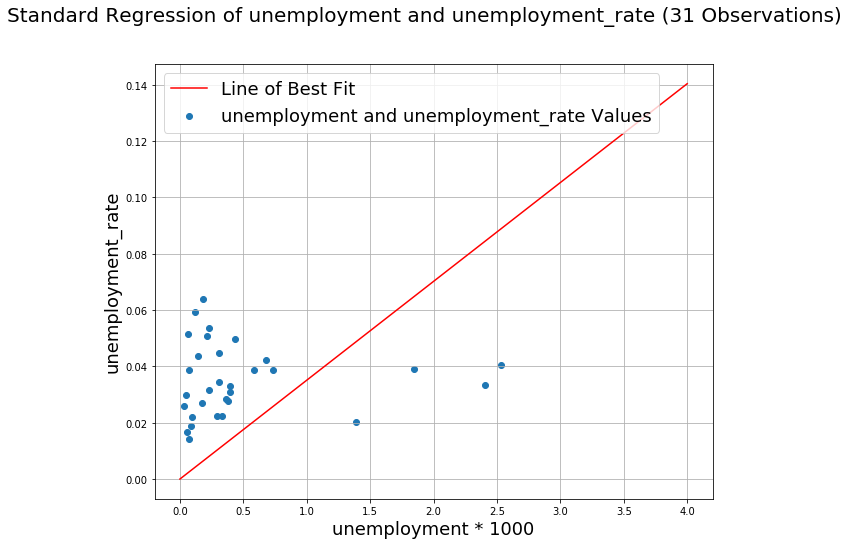

In [29]:
grad_std_reg_1D(rg_x2, rg_yy)

grad_std_reg_1D(g_x2, g_yy)

*2-D Data Domain*

In [30]:
def grad_std_reg_2D(x1,x2,yy):
    XX = np.vstack([x1, x2]).T
    AA = (np.linalg.inv(XX.T.dot(XX)).dot(XX.T)).dot(yy)
    xx1 = [0,0,4,4]
    xx2 = [0,4,0,4]
    xxx = [xx1,xx2]
    yy1 = np.matmul(AA,xxx)
    yy2 = np.reshape(yy1,(2,2))
    mg1,mg2 = np.meshgrid([0,4],[0,4])
    figure = plt.figure(figsize=(12,10))
    ax = figure.add_subplot(111, projection='3d')
    title = ('Standard Regression of employment, unemployment, and unemployment_rate (%d Observations)' % len(x1))
    figure.suptitle(title, fontsize=20)
    ax.scatter(x1,x2,yy,label='employment, unemployment, and unemployment_rate Values',c='r')
    ax.plot_surface(mg1,mg2,yy2,label='Line of Best Fit',color='b')
    ax.set_xlabel("employment * 1000", fontsize=16)
    ax.set_ylabel("unemployment * 1000", fontsize=16)
    ax.set_zlabel("unemployment_rate",fontsize=16)

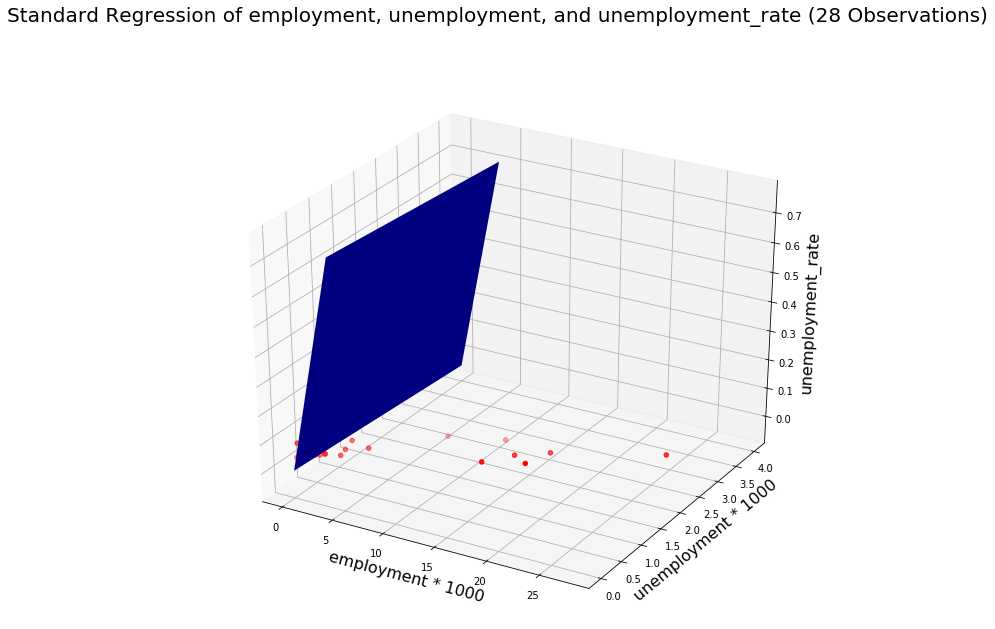

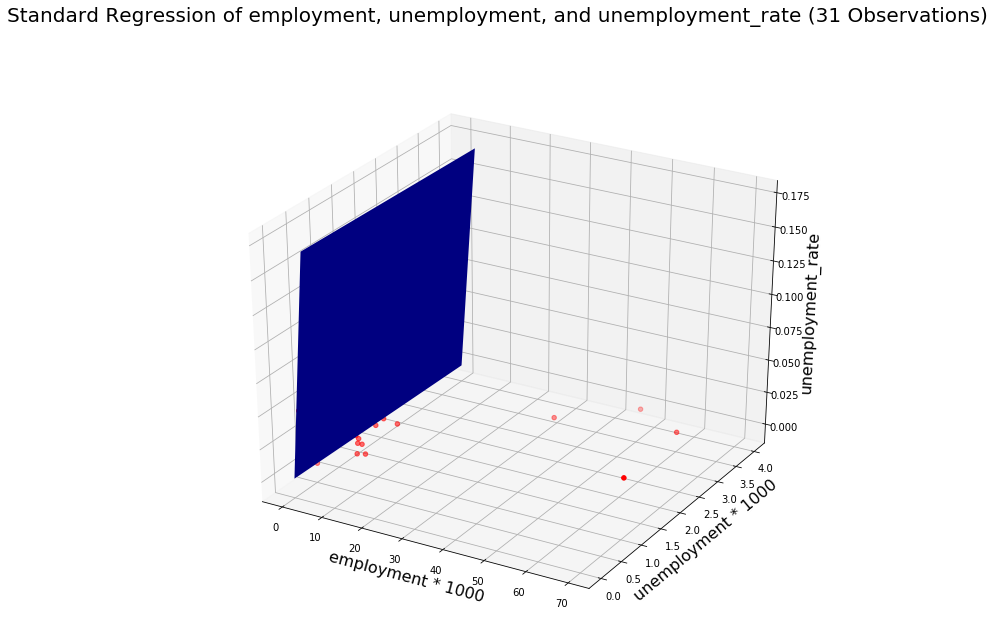

In [31]:
grad_std_reg_2D(rg_x1, rg_x2, rg_yy)

grad_std_reg_2D(g_x1, g_x2, g_yy)

**Ridge Regression**

*1-D Data Domain*

In [32]:
def grad_ridge_reg_1D(x,y):
    _lambda = 0.1
    X = np.vstack([x, np.ones(len(x))]).T
    A = (np.linalg.inv(X.T.dot(X) + _lambda).dot(X.T)).dot(y)
    xt = [0,4]
    yt = A * xt
    title = ('Ridge Regression of unemployment and unemployment_rate (%d Observations)' % len(x))
    plt.figure(figsize=(10,8)).suptitle(title, fontsize=20)
    plt.scatter(x, y, label='unemployment and unemployment_rate Values')
    plt.plot(xt, yt, 'r', label='Line of Best Fit')
    plt.xlabel("unemployment * 1000", fontsize=18)
    plt.ylabel("unemployment_rate", fontsize=18)
    plt.grid(True)
    plt.legend(fontsize=18)
    plt.show()

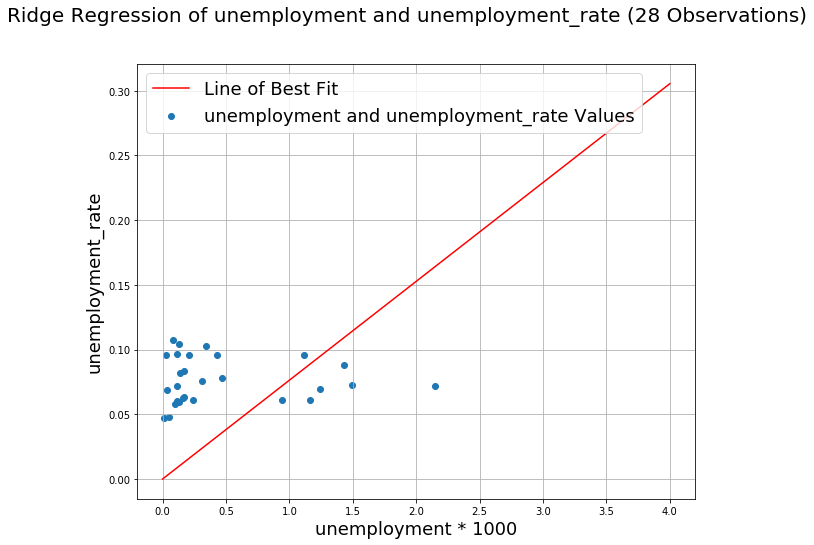

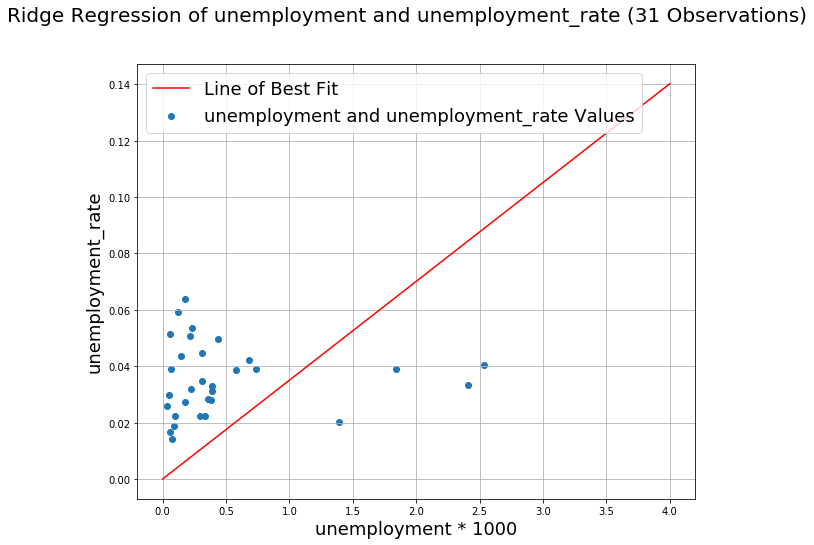

In [33]:
grad_ridge_reg_1D(rg_x2, rg_yy)

grad_ridge_reg_1D(g_x2, g_yy)

*2-D Data Domain*

In [34]:
def grad_ridge_reg_2D(x1,x2,yy):
    _lambda = 0.1
    XX = np.vstack([x1, x2]).T
    nn = len(XX.T.dot(XX))
    AA = (np.linalg.inv(XX.T.dot(XX) + (_lambda * np.eye(nn)))).dot(XX.T).dot(yy)
    xx1 = [0,0,4,4]
    xx2 = [0,4,0,4]
    xxx = [xx1,xx2]
    yy1 = np.matmul(AA,xxx)
    yy2 = np.reshape(yy1,(2,2))
    mg1,mg2 = np.meshgrid([0,4],[0,4])
    figure = plt.figure(figsize=(12,10))
    ax = figure.add_subplot(111, projection='3d')
    title = ('Ridge Regression of employment, unemployment, and unemployment_rate (%d Observations)' % len(x1))
    figure.suptitle(title, fontsize=20)
    ax.scatter(x1,x2,yy,label='employment, unemployment, and unemployment_rate Values',c='r')
    ax.plot_surface(mg1,mg2,yy2,label='Line of Best Fit',color='b')
    ax.set_xlabel("employment * 1000", fontsize=16)
    ax.set_ylabel("unemployment * 1000", fontsize=16)
    ax.set_zlabel("unemployment rate",fontsize=16)

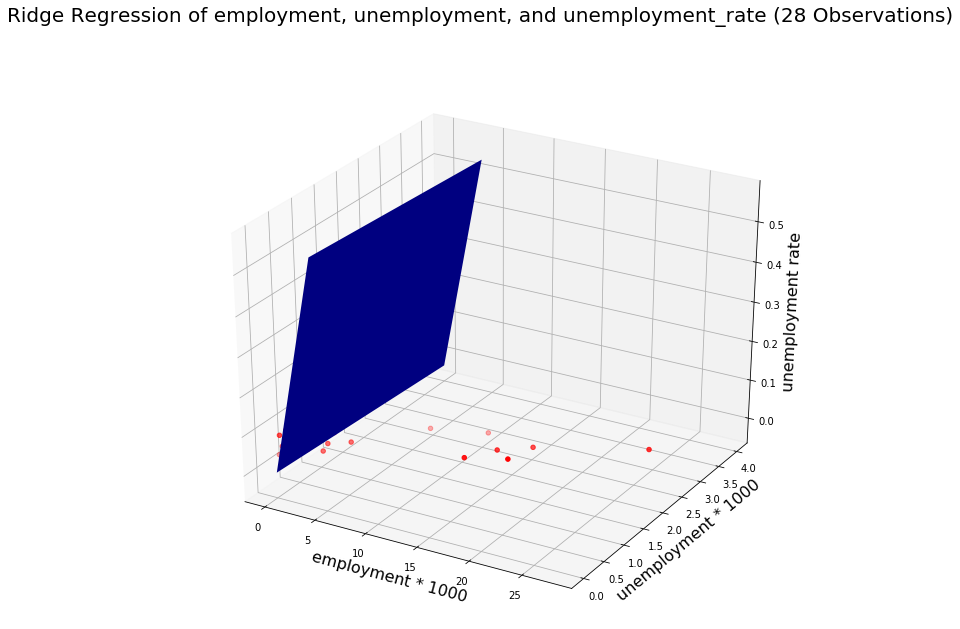

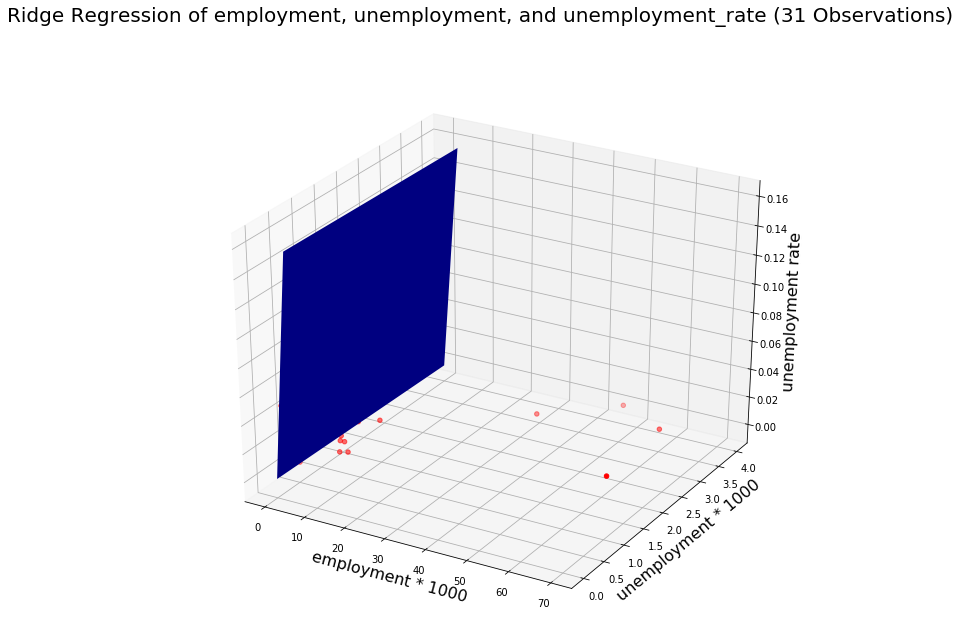

In [35]:
grad_ridge_reg_2D(rg_x1, rg_x2, rg_yy)

grad_ridge_reg_2D(g_x1, g_x2, g_yy)

**Lasso Regression**

*1-D Data Domain*

In [36]:
def grad_lasso_reg_1D(x,y):
    _lambda = 0.1
    X = np.vstack([x, np.ones(len(x))]).T
    A1 = (np.linalg.inv(X.T.dot(X)).dot(X.T)).dot(y)
    S = np.sign(A1)
    A = (np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y) - (S * _lambda / 2)))
    xt = [0,4]
    yt = A * xt
    title = ('Lasso Regression of unemployment and unemployment_rate (%d Observations)' % len(x))
    plt.figure(figsize=(10,8)).suptitle(title, fontsize=20)
    plt.scatter(x, y, label='unemployment and unemployment_rate Values')
    plt.plot(xt, yt, 'r', label='Line of Best Fit')
    plt.xlabel("unemployment * 1000", fontsize=18)
    plt.ylabel("unemployment_rate", fontsize=18)
    plt.grid(True)
    plt.legend(fontsize=18)
    plt.show()

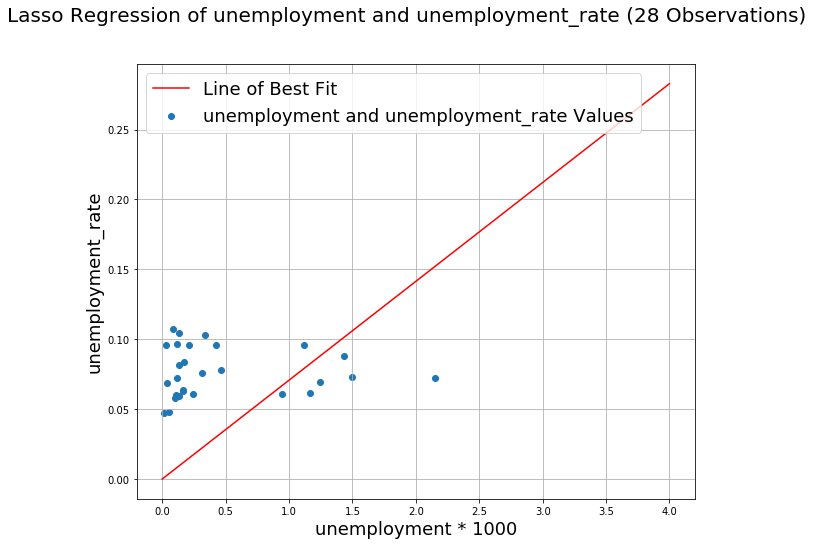

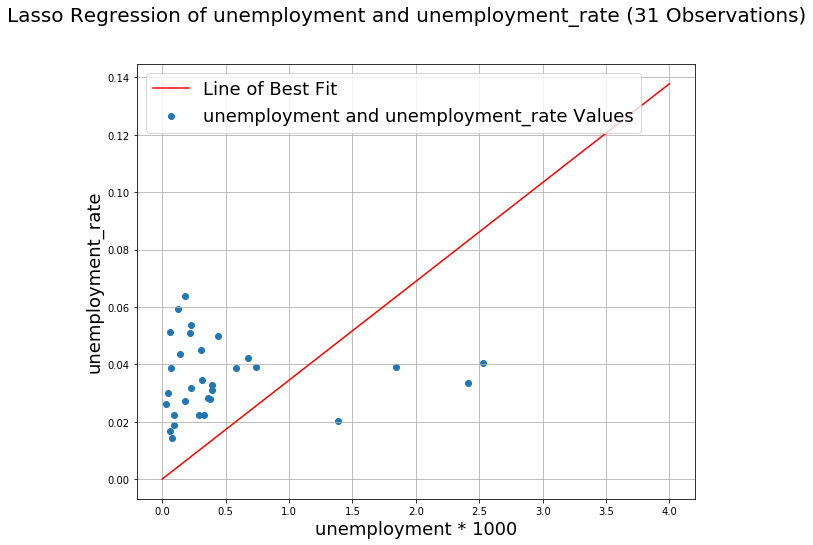

In [37]:
grad_lasso_reg_1D(rg_x2, rg_yy)

grad_lasso_reg_1D(g_x2, g_yy)

*1-D Data Domain*

In [38]:
def grad_lasso_reg_2D(x1,x2,yy):
    _lambda = 0.1
    XX = np.vstack([x1, x2]).T
    nn = len(XX.T.dot(XX))
    AA1 = (np.linalg.inv(XX.T.dot(XX))).dot(XX.T).dot(yy)
    SS = np.sign(AA1)
    AA = (np.linalg.inv(XX.T.dot(XX)).dot(XX.T.dot(yy) - (SS * _lambda / 2)))
    xx1 = [0,0,4,4]
    xx2 = [0,4,0,4]
    xxx = [xx1,xx2]
    yy1 = np.matmul(AA,xxx)
    yy2 = np.reshape(yy1,(2,2))
    mg1,mg2 = np.meshgrid([0,4],[0,4])
    figure = plt.figure(figsize=(12,10))
    ax = figure.add_subplot(111, projection='3d')
    title = ('Lasso Regression of employment, unemployment, and unemployment_rate (%d Observations)' % len(x1))
    figure.suptitle(title, fontsize=20)
    ax.scatter(x1,x2,yy,label='employment, unemployment, and unemployment_rate Values',c='r')
    ax.plot_surface(mg1,mg2,yy2,label='Line of Best Fit',color='b')
    ax.set_xlabel("employment * 1000", fontsize=16)
    ax.set_ylabel("unemployment * 1000", fontsize=16)
    ax.set_zlabel("unemployment_rate",fontsize=16)

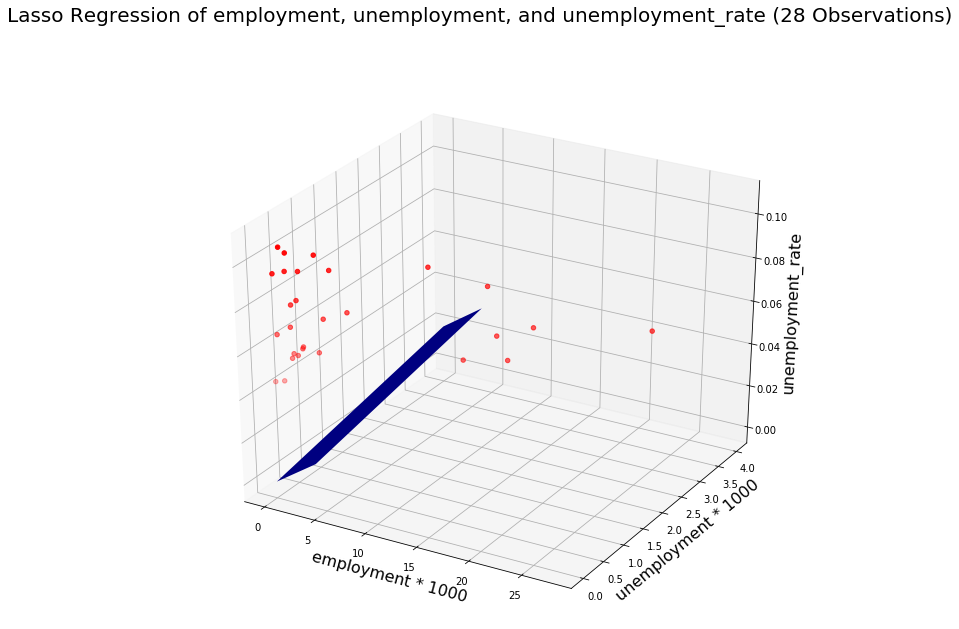

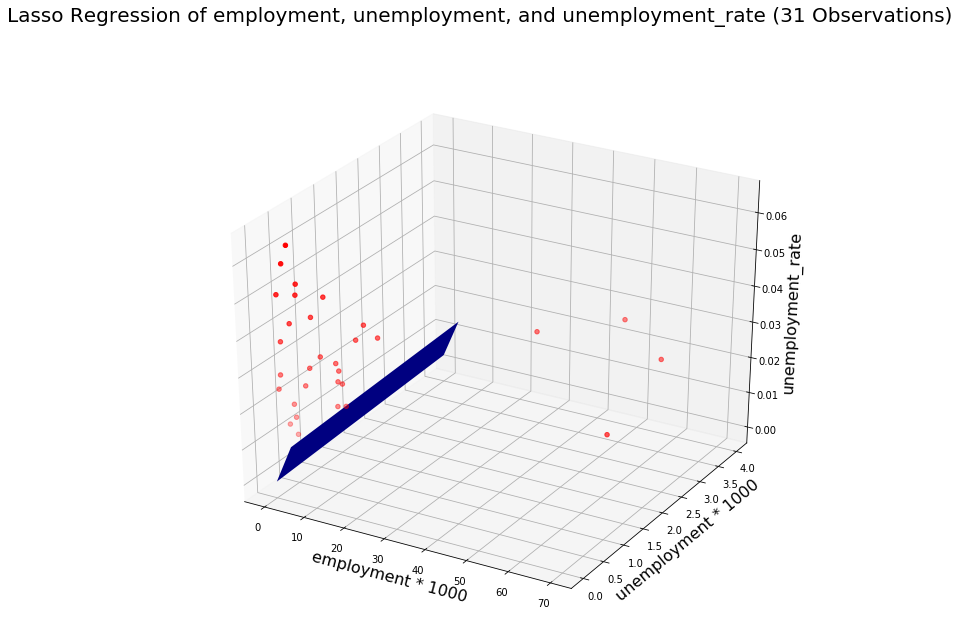

In [39]:
grad_lasso_reg_2D(rg_x1, rg_x2, rg_yy)

grad_lasso_reg_2D(g_x1, g_x2, g_yy)

**Elastic-Net Regression**

*1-D Data Domain*

In [40]:
def grad_en_reg_1D(x,y):
    lambda1 = 0.1
    lambda2 = 0.2
    X = np.vstack([x, np.ones(len(x))]).T
    A1 = (np.linalg.inv(X.T.dot(X)).dot(X.T)).dot(y)
    S = np.sign(A1)
    A = (np.linalg.inv(X.T.dot(X) + lambda1).dot(X.T.dot(y) - (S * lambda2 / 2)))
    xt = [0,4]
    yt = A * xt
    title = ('Elasctic-Net Regression of unemployment and unemployment_rate (%d Observations)' % len(x))
    plt.figure(figsize=(10,8)).suptitle(title, fontsize=20)
    plt.scatter(x, y, label='unemployment and unemployment_rate Values')
    plt.plot(xt, yt, 'r', label='Line of Best Fit')
    plt.xlabel("unemployment * 1000", fontsize=18)
    plt.ylabel("unemployment_rate", fontsize=18)
    plt.grid(True)
    plt.legend(fontsize=18)
    plt.show()

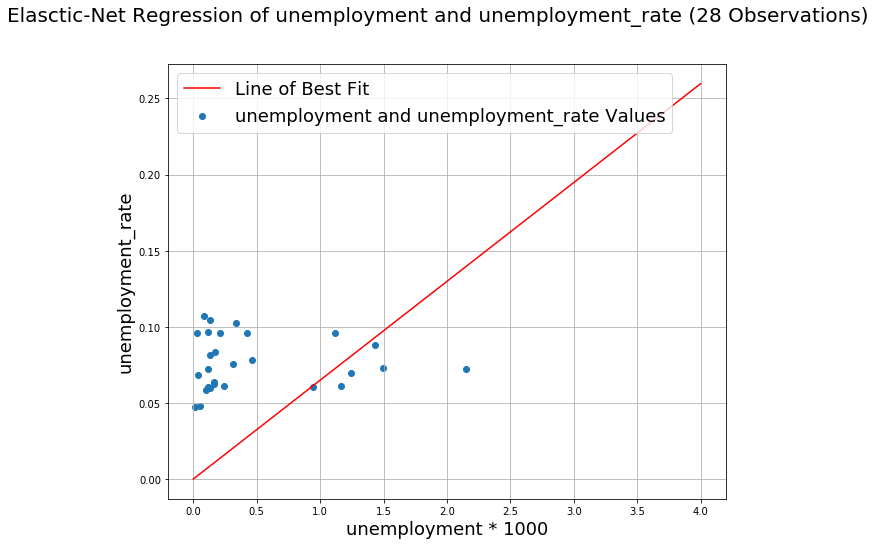

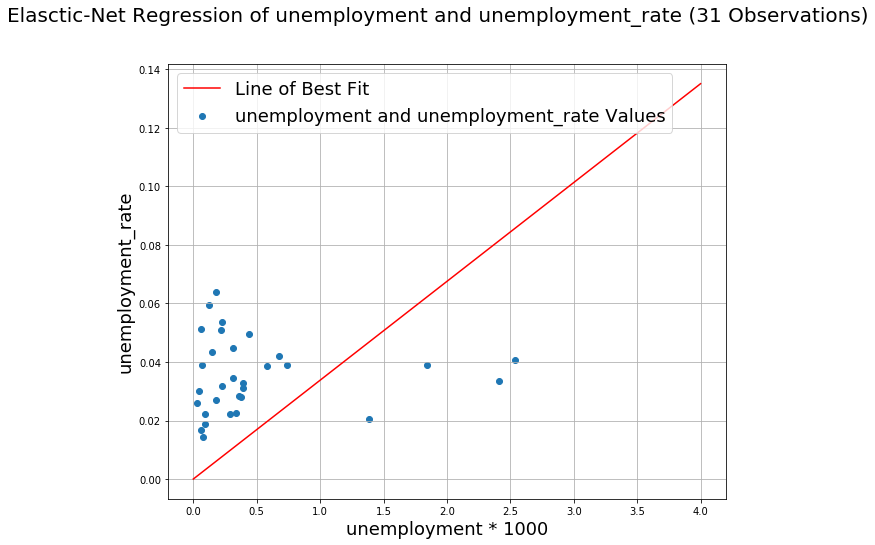

In [41]:
grad_en_reg_1D(rg_x2, rg_yy)

grad_en_reg_1D(g_x2, g_yy)

In [42]:
def grad_en_reg_2D(x1,x2,yy):
    lambda1 = 0.1
    lambda2 = 0.2
    XX = np.vstack([x1, x2]).T
    nn = len(XX.T.dot(XX))
    AA1 = (np.linalg.inv(XX.T.dot(XX))).dot(XX.T).dot(yy)
    SS = np.sign(AA1)
    AA = (np.linalg.inv(XX.T.dot(XX) + (lambda1 * np.eye(nn))).dot(XX.T.dot(yy) - (SS * lambda2 / 2)))
    xx1 = [0,0,4,4]
    xx2 = [0,4,0,4]
    xxx = [xx1,xx2]
    yy1 = np.matmul(AA,xxx)
    yy2 = np.reshape(yy1,(2,2))
    mg1,mg2 = np.meshgrid([0,4],[0,4])
    figure = plt.figure(figsize=(12,10))
    ax = figure.add_subplot(111, projection='3d')
    title = ('Elastic-Net Regression of employment, unemployment, and unemployment_rate (%d Observations)' % len(x1))
    figure.suptitle(title, fontsize=20)
    ax.scatter(x1,x2,yy,label='employment, unemployment, and unemployment_rate Values',c='r')
    ax.plot_surface(mg1,mg2,yy2,label='Line of Best Fit',color='b')
    ax.set_xlabel("employment * 1000", fontsize=16)
    ax.set_ylabel("unemployment * 1000", fontsize=16)
    ax.set_zlabel("unemployment_rate",fontsize=16)

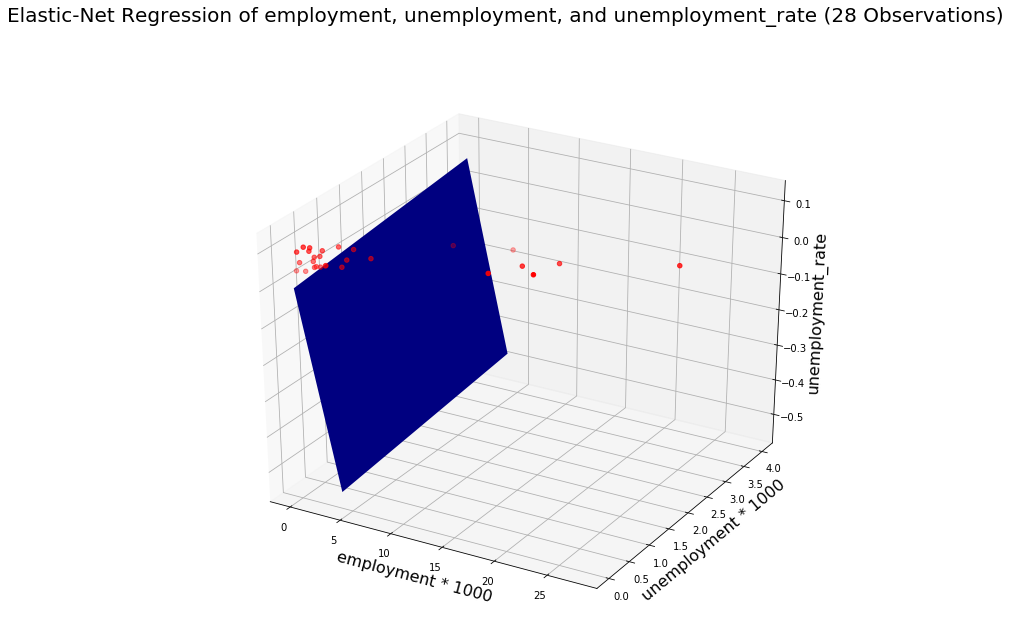

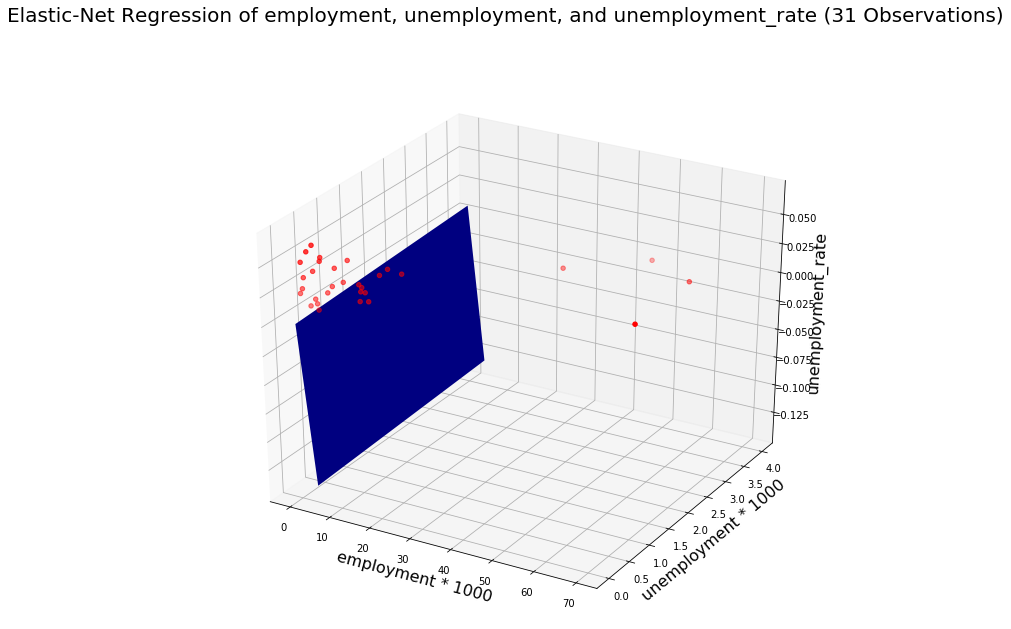

In [43]:
grad_en_reg_2D(rg_x1, rg_x2, rg_yy)

grad_en_reg_2D(g_x1, g_x2, g_yy)

## *Network Intrusion Dataset and Random Forest*

In [44]:
v1 = sqlContext.read.csv("../../data/CSC-510_Assignment2_Data/nslkdd-version1.csv", inferSchema="true", header=True).na.drop()
v2 = sqlContext.read.csv("../../data/CSC-510_Assignment2_Data/nslkdd-version2.csv", inferSchema="true", header=True).na.drop()

In [45]:
print("Number of nslkdd-version1.csv observations:", v1.count())
print("Number of nslkdd-version2.csv observations:", v2.count())

Number of nslkdd-version1.csv observations: 25192
Number of nslkdd-version2.csv observations: 25192


In [46]:
v1_feats = [c[0] for c in v1.dtypes if c[1] == "int" or c[1] == "double"]
v2_feats = [c[0] for c in v2.dtypes if (c[1] == "int" or c[1] == "double") and c[0] != "a42"]

In [47]:
for col in v1_feats:
    v1.describe([col]).show()

+-------+------------------+
|summary|                a1|
+-------+------------------+
|  count|             25192|
|   mean|305.05410447761193|
| stddev| 2686.555640061755|
|    min|                 0|
|    max|             42862|
+-------+------------------+

+-------+------------------+
|summary|                a5|
+-------+------------------+
|  count|             25192|
|   mean|24330.628215306446|
| stddev| 2410805.402027761|
|    min|                 0|
|    max|         381709090|
+-------+------------------+

+-------+------------------+
|summary|                a6|
+-------+------------------+
|  count|             25192|
|   mean|3491.8471737059385|
| stddev| 88830.71832952353|
|    min|                 0|
|    max|           5151385|
+-------+------------------+

+-------+--------------------+
|summary|                  a7|
+-------+--------------------+
|  count|               25192|
|   mean|7.939028262940616E-5|
| stddev|0.008909945628106706|
|    min|                   

+-------+-------------------+
|summary|                a36|
+-------+-------------------+
|  count|              25192|
|   mean|0.14745276278184874|
| stddev|0.30836659108783937|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+

+-------+--------------------+
|summary|                 a37|
+-------+--------------------+
|  count|               25192|
|   mean|0.031844236265478706|
| stddev| 0.11057496885808385|
|    min|                 0.0|
|    max|                 1.0|
+-------+--------------------+

+-------+------------------+
|summary|               a38|
+-------+------------------+
|  count|             25192|
|   mean|0.2858002540489096|
| stddev|0.4453164751115453|
|    min|               0.0|
|    max|               1.0|
+-------+------------------+

+-------+------------------+
|summary|               a39|
+-------+------------------+
|  count|             25192|
|   mean|0.2798463798031175|
| stddev|0.4460753261474882|
|    min|    

In [48]:
for col in v2_feats:
    v2.describe([col]).show()

+-------+--------------------+
|summary|                  a7|
+-------+--------------------+
|  count|               25192|
|   mean|7.939028262940616E-5|
| stddev|0.008909945628106706|
|    min|                   0|
|    max|                   1|
+-------+--------------------+

+-------+--------------------+
|summary|                  a8|
+-------+--------------------+
|  count|               25192|
|   mean|0.023737694506192442|
| stddev| 0.26022077717098974|
|    min|                   0|
|    max|                   3|
+-------+--------------------+

+-------+--------------------+
|summary|                  a9|
+-------+--------------------+
|  count|               25192|
|   mean|7.939028262940616E-5|
| stddev|0.008909945628106706|
|    min|                   0|
|    max|                   1|
+-------+--------------------+

+-------+--------------------+
|summary|                 a10|
+-------+--------------------+
|  count|               25192|
|   mean|0.023737694506192442|
| std

+-------+------------------+
|summary|               a38|
+-------+------------------+
|  count|             25192|
|   mean|0.2858002540489096|
| stddev|0.4453164751115453|
|    min|               0.0|
|    max|               1.0|
+-------+------------------+

+-------+------------------+
|summary|               a39|
+-------+------------------+
|  count|             25192|
|   mean|0.2798463798031175|
| stddev|0.4460753261474882|
|    min|               0.0|
|    max|               1.0|
+-------+------------------+

+-------+-------------------+
|summary|                a40|
+-------+-------------------+
|  count|              25192|
|   mean|0.11780009526833982|
| stddev|0.30586924566877277|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+

+-------+-------------------+
|summary|                a41|
+-------+-------------------+
|  count|              25192|
|   mean|0.11876945061924482|
| stddev|0.31733346824600817|
|    min|                

In [49]:
print("Number of numerical features in nslkdd-version1:",
      len(v1_feats))
print("\nNumber of numerical features in nslkdd-version2:",
      len(v2_feats))

Number of numerical features in nslkdd-version1: 38

Number of numerical features in nslkdd-version2: 35


In [54]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import math

def rand_forest_best_features(features, frame):
    label_type = frame.select("a42").dtypes[0][1] == "string"
    vector_assembler = VectorAssembler(inputCols=features, outputCol="features")
    frame_temp = vector_assembler.transform(frame)
    
    for col in frame.columns:
        if col != "a42":
            frame_temp = frame_temp.drop(col)
    
    if label_type == True: 
        str_indexer = StringIndexer(inputCol="a42", outputCol="a42_index")
        frame_temp = str_indexer.fit(frame_temp).transform(frame_temp)
        
    (train, test) = frame_temp.randomSplit([0.8, 0.2])
    label = "a42"
    
    if label_type == True:
        label = "a42_index"
    
    rf = RandomForestClassifier(labelCol=label, featuresCol="features", numTrees=5)
    model = rf.fit(train)
    pred = model.transform(test)
    evaluator = MulticlassClassificationEvaluator(labelCol=label, predictionCol='prediction',
                                                 metricName="accuracy")
    accuracy = evaluator.evaluate(pred)
    paramGrid = (ParamGridBuilder().addGrid(rf.maxDepth, [2,4,6])
                 .addGrid(rf.maxBins,[20,60]).addGrid(rf.numTrees,[10,20]).build())
    cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
    cv_model = cv.fit(train)
    cv_pred = cv_model.transform(test)
    cv_accuracy = evaluator.evaluate(cv_pred)
    
    return model.featureImportances, (1.0 - accuracy), (1.0 - cv_accuracy)

In [55]:
v1_rand_forest_best_feats = rand_forest_best_features(v1_feats, v1)
v1_val_of_importance = sorted(feat for feat in zip(v1_rand_forest_best_feats[0], v1_feats))
v1_best_features = []

print("Multiclass Classification Evaluator Test Error = %g" % v1_rand_forest_best_feats[1])
print("Cross Validation Test Error = %g" % v1_rand_forest_best_feats[2])
print("\nImportance of nslkdd-version1 features from least to greatest:")

for accuracy, feat_name in v1_val_of_importance:
    col_and_accuracy = (feat_name, np.round(accuracy, decimals=2))
    print("\tColumn '%s' has %s accuracy" % col_and_accuracy)
    
    if col_and_accuracy[1] >= np.round(v1_rand_forest_best_feats[2], decimals=2):
        v1_best_features.append(col_and_accuracy)

Multiclass Classification Evaluator Test Error = 0.061602
Cross Validation Test Error = 0.0214525

Importance of nslkdd-version1 features from least to greatest:
	Column 'a14' has 0.0 accuracy
	Column 'a15' has 0.0 accuracy
	Column 'a16' has 0.0 accuracy
	Column 'a17' has 0.0 accuracy
	Column 'a18' has 0.0 accuracy
	Column 'a19' has 0.0 accuracy
	Column 'a20' has 0.0 accuracy
	Column 'a21' has 0.0 accuracy
	Column 'a22' has 0.0 accuracy
	Column 'a31' has 0.0 accuracy
	Column 'a7' has 0.0 accuracy
	Column 'a9' has 0.0 accuracy
	Column 'a11' has 0.0 accuracy
	Column 'a41' has 0.0 accuracy
	Column 'a26' has 0.0 accuracy
	Column 'a28' has 0.0 accuracy
	Column 'a1' has 0.0 accuracy
	Column 'a12' has 0.0 accuracy
	Column 'a38' has 0.0 accuracy
	Column 'a10' has 0.0 accuracy
	Column 'a8' has 0.01 accuracy
	Column 'a24' has 0.01 accuracy
	Column 'a13' has 0.01 accuracy
	Column 'a36' has 0.01 accuracy
	Column 'a33' has 0.01 accuracy
	Column 'a6' has 0.01 accuracy
	Column 'a40' has 0.01 accuracy

In [56]:
v2_rand_forest_best_feats = rand_forest_best_features(v2_feats, v2)
v2_val_of_importance = sorted(feat for feat in zip(v2_rand_forest_best_feats[0], v2_feats))
v2_best_features = []
print("Multiclass Classification Evaluator Test Error = %g" % v2_rand_forest_best_feats[1])
print("Cross Validation Test Error = %g" % v2_rand_forest_best_feats[2])
print("\nImportance of nslkdd-version2 features from least to greatest:")

for accuracy, feat_name in v2_val_of_importance:
    col_and_accuracy = (feat_name, np.round(accuracy, decimals=2))
    print("\tColumn '%s' has %s accuracy" % col_and_accuracy)
    
    if col_and_accuracy[1] >= np.round(v2_rand_forest_best_feats[2], decimals=2):
        v2_best_features.append(col_and_accuracy)

Multiclass Classification Evaluator Test Error = 0.0639143
Cross Validation Test Error = 0.0375149

Importance of nslkdd-version2 features from least to greatest:
	Column 'a11' has 0.0 accuracy
	Column 'a13' has 0.0 accuracy
	Column 'a17' has 0.0 accuracy
	Column 'a18' has 0.0 accuracy
	Column 'a19' has 0.0 accuracy
	Column 'a20' has 0.0 accuracy
	Column 'a21' has 0.0 accuracy
	Column 'a22' has 0.0 accuracy
	Column 'a7' has 0.0 accuracy
	Column 'a9' has 0.0 accuracy
	Column 'a16' has 0.0 accuracy
	Column 'a12' has 0.0 accuracy
	Column 'a26' has 0.0 accuracy
	Column 'a10' has 0.0 accuracy
	Column 'a28' has 0.0 accuracy
	Column 'a15' has 0.01 accuracy
	Column 'a8' has 0.01 accuracy
	Column 'a29' has 0.01 accuracy
	Column 'a24' has 0.01 accuracy
	Column 'a31' has 0.01 accuracy
	Column 'a35' has 0.01 accuracy
	Column 'a27' has 0.01 accuracy
	Column 'a34' has 0.01 accuracy
	Column 'a33' has 0.02 accuracy
	Column 'a38' has 0.02 accuracy
	Column 'a14' has 0.02 accuracy
	Column 'a23' has 0.02 

In [57]:
print("The amount of most important features in nslkdd-version1:\n\t%d out of %d features"
      % (len(v1_best_features), len(v1_feats)))
print("The most important features in nslkdd-version1:\n\t%s"
      % [f[0] for f in v1_best_features])
print("The most important features' accuracies in nslkdd-version1:\n\t%s"
      % [f[1] for f in v1_best_features])
print("The total accuracy of the most important features in nslkdd-version1:\n\t%s"
      % sum([acc[1] for acc in v1_best_features]))
print("\n\nThe amount of most important features in nslkdd-version2:\n\t%d out of %d features"
      % (len(v2_best_features), len(v2_feats)))
print("The most important features in nslkdd-version2:\n\t%s"
      % [f[0] for f in v2_best_features])
print("The most important features' accuracies in nslkdd-version2:\n\t%s"
      % [f[1] for f in v2_best_features])
print("The total accuracy of the most important features in nslkdd-version2:\n\t%s"
      % sum([acc[1] for acc in v2_best_features]))

The amount of most important features in nslkdd-version1:
	11 out of 38 features
The most important features in nslkdd-version1:
	['a23', 'a34', 'a35', 'a30', 'a32', 'a37', 'a27', 'a25', 'a29', 'a5', 'a39']
The most important features' accuracies in nslkdd-version1:
	[0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.12, 0.16, 0.22, 0.23]
The total accuracy of the most important features in nslkdd-version1:
	0.89


The amount of most important features in nslkdd-version2:
	5 out of 35 features
The most important features in nslkdd-version2:
	['a40', 'a37', 'a25', 'a39', 'a30']
The most important features' accuracies in nslkdd-version2:
	[0.04, 0.08, 0.09, 0.12, 0.41]
The total accuracy of the most important features in nslkdd-version2:
	0.74
